In [139]:
# import modules
%matplotlib inline
import random
import pylab
import pandas as pd
import numpy as np
import cPickle as pkl
from PIL import Image
from lasagne import layers, updates
from theano.tensor.nnet import softmax
from nolearn.lasagne import NeuralNet, BatchIterator
from sklearn.cross_validation import train_test_split

(768, 1024, 3)


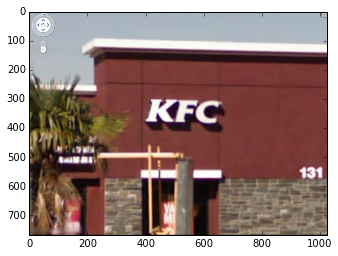

In [63]:
# test image
from scipy.misc import imread as ims
img = ims('/home/faizy/workspace/project/project/datasets/svt/svt1/img/00_13.jpg')#[292:450, 176:850, :]#img -> 00_12
print img.shape
# image[y:y + image_height, x:x + image_width, :]
pylab.imshow(img)
pylab.show()

In [11]:
# extra functions
def unpickle(filer):
    f = open(filer, 'rb')
    d_dict = pkl.load(f)
    f.close()
    return d_dict

In [121]:
def shiftup(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        # loop for shift up
        for j in range(32 - 10):
            shifted_dataset[i, 0, j:j+1, :] = dataset[i, 0, 10 + j : 10 + j + 1, :]
        for j in range(32 - 10, 32):
            shifted_dataset[i, 0, j:j+1, :] = shifted_dataset[i, :, 32 - 10 - 1, :]
    return shifted_dataset

In [7]:
def shiftdown(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        # loop for shift up
        for j in range(10, 32):
            shifted_dataset[i, 0, j:j+1, :] = dataset[i, 0, j - 10 : j + 1 - 10, :]
        for j in range(10):
            shifted_dataset[i, 0, j:j+1, :] = shifted_dataset[i, :, 10, :]
    return shifted_dataset

In [62]:
def shiftleft(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        for j in range(32 - 10):
            shifted_dataset[i, 0, :, j:j+1] = dataset[i, 0, :, 10 + j: 10 + j + 1]
        for j in range(32 - 10, 32):
            shifted_dataset[i, :, :, j] = shifted_dataset[i, :, :, 32 - 10 - 1]
    
    return shifted_dataset

In [89]:
def shiftright(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        for j in range(10, 32):
            shifted_dataset[i, 0, :, j : j + 1] = dataset[i, 0, :, j - 10 : j + 1 - 10]
        for j in range(10):
            shifted_dataset[i, 0, :, j] = dataset[i, 0, :, 0]
    
    return shifted_dataset

In [12]:
# load train_test set
# cifar
train_dict = unpickle('/home/faizy/workspace/cifar/cifar-10-batches-py/data_batch_1')
train2_images = train_dict['data'].astype('float32')
train2_y = np.zeros((10000, )).astype('int')
test_dict = unpickle('/home/faizy/workspace/cifar/cifar-10-batches-py/test_batch')
test2_images = test_dict['data'].astype('float32')

# chars74k
data = pd.read_csv('/home/faizy/workspace/project/project/scripts/LISTFILE.txt', sep = ' ', header = None)
root = '/home/faizy/workspace/project/project/datasets/English/'
data_x = np.zeros((data.shape[0], 1, 32, 32))
data_y = np.ones((data.shape[0], )).astype('int32')
from scipy.misc import imread, imresize
for idx, path in enumerate(data[0]):
    img = imread(root + path)
    img = imresize(img, (32, 32))
    if len(img.shape) == 3:
        data_x[idx, ...] = img.dot([0.299, 0.587, 0.144])
    else:
        data_x[idx, ...] = img
        
data_x = data_x.astype('float32')
train1_x, test1_x, train1_y, test1_y = train_test_split(data_x, data_y, test_size = 0.2)

In [122]:
# Augmented data
train3_x = shiftup(train1_x)
train4_x = shiftdown(train1_x)
train5_x = shiftleft(train1_x)
train6_x = shiftright(train1_x)

train3_y = np.zeros((train3_x.shape[0], )).astype('int')
train4_y = np.zeros((train4_x.shape[0], )).astype('int')
train5_y = np.zeros((train5_x.shape[0], )).astype('int')
train6_y = np.zeros((train6_x.shape[0], )).astype('int')

In [126]:
print train1_x.shape, train2_images.shape, train3_x.shape, train4_x.shape, train5_x.shape, train6_x.shape

(6164, 1, 32, 32) (10000, 3072) (6164, 1, 32, 32) (6164, 1, 32, 32) (6164, 1, 32, 32) (6164, 1, 32, 32)


In [127]:
# preprocess
# cifar
train2_images /= train2_images.std(axis = None)
train2_images -= train2_images.mean()

test2_images /= test2_images.std(axis = None)
test2_images -= test2_images.mean()

# chars74k
train1_x /= train1_x.std(axis = None)
train1_x -= train1_x.mean()

test1_x /= test1_x.std(axis = None)
test1_x -= test1_x.mean()

# augmented data

train3_x /= train3_x.std(axis = None)
train3_x -= train3_x.mean()

train4_x /= train4_x.std(axis = None)
train4_x -= train4_x.mean()

train5_x /= train5_x.std(axis = None)
train5_x -= train5_x.mean()

train6_x /= train6_x.std(axis = None)
train6_x -= train6_x.mean()

In [128]:
# reshape dataset
# cifar
# grayscaling and cropping to size
train2_x_rgb = train2_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

train2_x = np.zeros((10000, 1, 32, 32))
for i in range(10000):
    train2_x[i, :, :, :] = np.dot(train2_x_rgb[i, :, :, :], [0.299, 0.587, 0.144])

test2_x_rgb = test2_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

test2_x = np.zeros((10000, 1, 32, 32))
for i in range(10000):
    test2_x[i, :, :, :] = np.dot(test2_x_rgb[i, :, :, :], [0.299, 0.587, 0.144])

In [134]:
# finally
#train_x = np.vstack((train1_x, train2_x))
train_x = np.vstack((train1_x, train3_x))
train_x = np.vstack((train_x, train4_x))
train_x = np.vstack((train_x, train5_x))
train_x = np.vstack((train_x, train6_x))

train_y = np.concatenate([train1_y, train3_y, train4_y, train5_y, train6_y])#train2_y, 

test_x = test1_x#np.vstack((test1_x, test2_x))

test_y = test1_y

In [135]:
# check again
train_x = train_x.astype('float32')
train_y = train_y.astype('int32')
test_x = test_x.astype('float32')
test_y = test_y.astype('int32')

In [142]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 1, 32, 32),
    conv1_num_filters = 32, conv1_filter_size = (10, 10),
    pool1_pool_size = (2, 2),
    dropout1_p = 0.2,
    hidden4_num_units = 128,
    output_num_units = 2, output_nonlinearity = softmax,

    batch_iterator_train = BatchIterator(batch_size = 1000),
    batch_iterator_test = BatchIterator(batch_size = 1000),

    update=updates.adam,

    use_label_encoder = True,
    regression = False,
    max_epochs = 500,
    verbose = 1,
)

In [143]:
# train and test nn
net.fit(train_x, train_y)
pred = net.predict(test_x)

# Neural Network with 499234 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x32x32
  1  conv1     32x23x23
  2  pool1     32x11x11
  3  dropout1  32x11x11
  4  hidden4   128
  5  output    2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       2.04943       0.68469      2.99323      0.82386  8.94s
      2       0.68016       0.67585      1.00637      0.82386  8.68s
      3       0.67224       0.66743      1.00722      0.82386  8.69s
      4       0.66452       0.65923      1.00803      0.82386  8.69s
      5       0.65704       0.65129      1.00883      0.82386  14.68s
      6       0.64983       0.64363      1.00962      0.82386  8.68s
      7       0.64290       0.63627      1.01041      0.82386  8.68s
      8       0.63626       0.62921      1.01120      0.82386  10.16s
      9       0.62990       0.62243      1.01200      0.82386

In [17]:
f = open('/home/faizy/workspace/project/project/models/detector_2.pkl', 'wb')
pkl.dump(net, f)
f.close()

In [144]:
from sklearn.metrics import accuracy_score, classification_report
print classification_report(test_y, pred)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00      1541

avg / total       0.00      0.00      0.00      1541



In [72]:
from sklearn.feature_extraction import image
patches = image.extract_patches(img, (100, 60, 3), extraction_step = 5)
print patches.shape

(134, 193, 1, 100, 60, 3)


In [73]:
from scipy.misc import imresize
new_lst = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        new_lst.append(imresize(patches[i, j, 0, :, :, :], (32, 32)))
        
print len(new_lst)

25862


In [74]:
new_list = np.stack(new_lst)
new_list = new_list.dot([0.299, 0.587, 0.144])
tester = new_list.reshape(patches.shape[0]*patches.shape[1], 1, 32, 32)

In [75]:
tester /= tester.std(axis = None)
tester -= tester.mean()
tester = tester.astype('float32')

In [76]:
print tester.shape

(25862, 1, 32, 32)


In [77]:
preder = net.predict_proba(tester)

In [78]:
heatmap = preder[:, 1].reshape((patches.shape[0], patches.shape[1]))
print heatmap.shape

(134, 193)


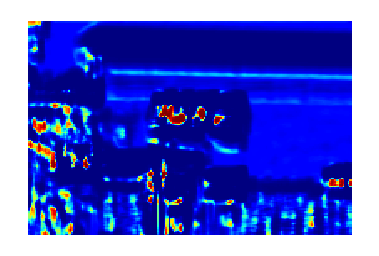

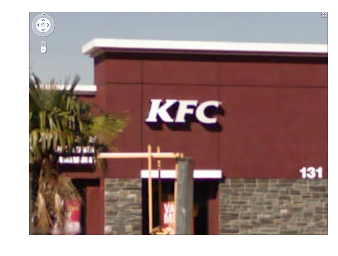

In [79]:
pylab.pcolor(heatmap[::-1])
pylab.axis('off')
pylab.show()
pylab.imshow(img)
pylab.axis('off')
pylab.show()

In [54]:
preder.shape

(22940,)

In [23]:
def visualize(dataset):
        '''This function visualizes data
        
        Input : numpy array (image_number, color_channels, height, width)
        '''
        i = random.randrange(0, dataset.shape[0])
        img = np.reshape(dataset[i, ...], ( dataset.shape[2], dataset.shape[3] ))
        pylab.imshow(img)
        pylab.gray()
        pylab.show()

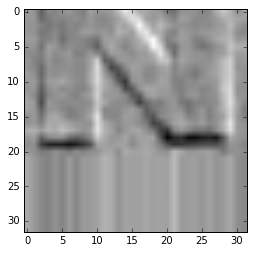

In [125]:
visualize(train3_x)

In [138]:
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)